In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import load_model
from keras.regularizers import l2

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from shared import read_dataset, plot_results, evaluate_price_predictions, mean_abs_error

2023-12-02 17:56:20.692947: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-02 17:56:20.721624: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 17:56:20.721657: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 17:56:20.721675: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 17:56:20.727140: I tensorflow/core/platform/cpu_feature_g

In [3]:
start = "2010-01-01"
end = "2023-01-01"
target_column_name = 'Close'
path = '../models/lstm_model/predictor_adj_close.h5'

AZM = read_dataset('../data/AZM.MI_ta.csv', start, end)

data = AZM
data.dropna(inplace=True)

cols = [target_column_name] + [ col for col in data if col != target_column_name]
target_column = list(data.columns).index(target_column_name)
data = data[cols]

print(f"#Trading Days: {data.shape}")

#Trading Days: (3284, 23)


#Trading Days: (2495, 21)

In [4]:
SEQUENCE_LENGTH = 100
PREDICTION_LENGTH = 5

# Define feature array and target array to train the model.
data_array = np.array(data.values)
target_array = np.array(data[target_column_name].values).reshape(-1, 1)

# Normalize the data
scaler_data = MinMaxScaler()
scaler_data.fit(data_array)
data_array = scaler_data.transform(data_array)

scaler_target = MinMaxScaler()
scaler_target.fit(target_array)
target_array = scaler_target.transform(target_array)

# Split the data
train_size = int(len(data_array) * 0.90)
evaluation_size = int(len(data_array) * 0.0) # no evaluation

def create_sequences(data, target, seq_length, pred_length):
    sequence_data = []
    sequence_target = []
    for i in range(seq_length, len(data) - pred_length + 1):
        sequence_data.append(data[i - seq_length:i])
        sequence_target.append(target[i:i + pred_length].flatten())
    return np.array(sequence_data), np.array(sequence_target)

data_sequences, target_sequences = create_sequences(data_array, target_array, SEQUENCE_LENGTH, PREDICTION_LENGTH)

train_data, validation_data, test_data = data_sequences[:train_size], data_sequences[train_size:train_size+evaluation_size], data_sequences[train_size+evaluation_size:]
train_target, validation_target, test_target = target_sequences[:train_size], target_sequences[train_size:train_size+evaluation_size], target_sequences[train_size+evaluation_size:]

In [5]:
# TESTING CORRECTNESS OF GENERATED SEQUENCES
test_index = -1
test_column_prompt = 0
a = scaler_data.inverse_transform(data_sequences[test_index])
b = scaler_target.inverse_transform(target_sequences)

for i in range (0, SEQUENCE_LENGTH):
    print(f"A[{i}]: {a[i][test_column_prompt]}")

print(f'b: {b[test_index]}')

A[0]: 17.284999847412106
A[1]: 16.909999847412106
A[2]: 16.95499992370605
A[3]: 16.834999084472656
A[4]: 17.149999618530273
A[5]: 17.20000076293945
A[6]: 17.27499961853027
A[7]: 17.360000610351562
A[8]: 17.049999237060543
A[9]: 17.155000686645504
A[10]: 16.57999992370605
A[11]: 16.32999992370605
A[12]: 16.549999237060547
A[13]: 16.53499984741211
A[14]: 16.430000305175778
A[15]: 15.97000026702881
A[16]: 15.949999809265135
A[17]: 16.174999237060543
A[18]: 15.9350004196167
A[19]: 15.59000015258789
A[20]: 16.165000915527344
A[21]: 15.925000190734863
A[22]: 16.0049991607666
A[23]: 16.03499984741211
A[24]: 15.97000026702881
A[25]: 16.399999618530273
A[26]: 16.805000305175778
A[27]: 16.700000762939453
A[28]: 16.690000534057617
A[29]: 16.5049991607666
A[30]: 16.325000762939453
A[31]: 16.434999465942383
A[32]: 15.859999656677243
A[33]: 15.979999542236326
A[34]: 15.574999809265137
A[35]: 15.119999885559082
A[36]: 15.125
A[37]: 14.864999771118162
A[38]: 14.720000267028809
A[39]: 14.23999977111816

In [6]:
def build_model(input_shape, l2_value):
    """LSTM model"""
    model = keras.Sequential()
    model.add(keras.layers.Bidirectional(
        keras.layers.LSTM(3, return_sequences=True, kernel_regularizer=l2(l2_value), recurrent_regularizer=l2(l2_value), bias_regularizer=l2(l2_value)),
        input_shape=input_shape)
    )
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=PREDICTION_LENGTH))
    return model

def train_model(model, train_data, train_target, epochs=30, batch_size=256, patience=20):
    model.compile(optimizer='adam', loss='mean_absolute_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        verbose=2,
        mode='min',
        restore_best_weights=True,
    )

    model.fit(
        [train_data], # input
        train_target,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        validation_split=0.2,
        callbacks=[early_stopping]
    )

In [7]:
batch_size = 512
epochs = 900
patience = 30
l2_value = 0.01

## GENERATE MODEL ##
model = build_model(input_shape=(train_data.shape[1], train_data.shape[2]), l2_value=l2_value)
# np.expand_dims(train_data, axis=2)
train_model(model, train_data, train_target, epochs=epochs, batch_size=batch_size, patience=patience)

## LOAD MODEL ##
# model = load_model(path_price_generator)

2023-12-02 17:56:26.306081: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-12-02 17:56:26.306119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: andrea
2023-12-02 17:56:26.306124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: andrea
2023-12-02 17:56:26.306468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.129.3
2023-12-02 17:56:26.306485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.129.3
2023-12-02 17:56:26.306488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.129.3


Epoch 1/900
5/5 - 2s - loss: 0.8184 - val_loss: 0.7059 - 2s/epoch - 466ms/step
Epoch 2/900
5/5 - 0s - loss: 0.6219 - val_loss: 0.5587 - 157ms/epoch - 31ms/step
Epoch 3/900
5/5 - 0s - loss: 0.5646 - val_loss: 0.5600 - 147ms/epoch - 29ms/step
Epoch 4/900
5/5 - 0s - loss: 0.5446 - val_loss: 0.5171 - 151ms/epoch - 30ms/step
Epoch 5/900
5/5 - 0s - loss: 0.5037 - val_loss: 0.5224 - 146ms/epoch - 29ms/step
Epoch 6/900
5/5 - 0s - loss: 0.4889 - val_loss: 0.4997 - 153ms/epoch - 31ms/step
Epoch 7/900
5/5 - 0s - loss: 0.4726 - val_loss: 0.4934 - 151ms/epoch - 30ms/step
Epoch 8/900
5/5 - 0s - loss: 0.4587 - val_loss: 0.4651 - 153ms/epoch - 31ms/step
Epoch 9/900
5/5 - 0s - loss: 0.4437 - val_loss: 0.4632 - 150ms/epoch - 30ms/step
Epoch 10/900
5/5 - 0s - loss: 0.4304 - val_loss: 0.4434 - 151ms/epoch - 30ms/step
Epoch 11/900
5/5 - 0s - loss: 0.4184 - val_loss: 0.4387 - 153ms/epoch - 31ms/step
Epoch 12/900
5/5 - 0s - loss: 0.4064 - val_loss: 0.4251 - 157ms/epoch - 31ms/step
Epoch 13/900
5/5 - 0s - los

In [11]:
scaler_target.inverse_transform([test_target[1]])

array([[23.81999969, 23.73999977, 22.95999908, 23.60000038, 23.65999985]])

In [12]:
price_predicted_array[1]

array([23.320194, 23.46241 , 23.330912, 23.296318, 23.178535],
      dtype=float32)

In [8]:
data_to_predict = test_data
actual_prediction = test_target

price_predicted_array = scaler_target.inverse_transform(model.predict(test_data))

8/8 [==============================] - 0s 4ms/step


In [10]:
data_to_predict = (test_data)
actual_prediction = test_target

# TESTing: DENORMALIZE TARGET AND PREDICTIONS ##
price_predicted_array = scaler_target.inverse_transform(model.predict(data_to_predict))
price_actual_array = scaler_target.inverse_transform(actual_prediction).flatten()


def evaluate_5_day_predictions(predicted, actual):
    # Calculate metrics for each day and average
    mae_list, mse_list, rmse_list, mape_list, r2_list = [], [], [], [], []
    
    for i in range(5):
        mae = mean_absolute_error(actual[:, i], predicted[:, i])
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((actual[:, i] - predicted[:, i]) / actual[:, i])) * 100
        r2 = r2_score(actual[:, i], predicted[:, i])

        mae_list.append(mae)
        mse_list.append(mse)
        rmse_list.append(rmse)
        mape_list.append(mape)
        r2_list.append(r2)

    # Averaging the metrics across 5 days
    avg_mae = np.mean(mae_list)
    avg_mse = np.mean(mse_list)
    avg_rmse = np.mean(rmse_list)
    avg_mape = np.mean(mape_list)
    avg_r2 = np.mean(r2_list)

    return {
        'MAE': avg_mae,
        'MSE': avg_mse,
        'RMSE': avg_rmse,
        'MAPE': avg_mape,
        'R2': avg_r2,
    }

# Use this function to evaluate your predictions
evaluation_results = evaluate_5_day_predictions(price_predicted_array, price_actual_array)
print("Evaluation Results:", evaluation_results)


8/8 [==============================] - 0s 3ms/step


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

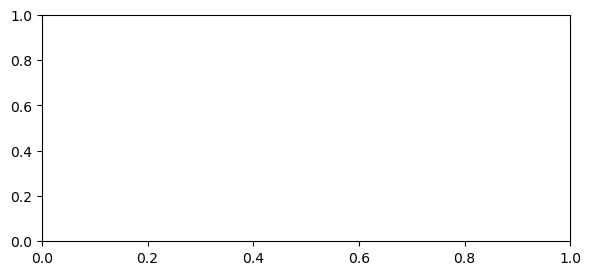

In [11]:
def plot_5_day_results(actual, predicted, column_name):
    plt.figure(figsize=(15, 10))

    for i in range(5):
        plt.subplot(3, 2, i + 1)
        plt.plot(actual[:, i], label='Actual Day ' + str(i + 1))
        plt.plot(predicted[:, i], label='Predicted Day ' + str(i + 1))
        plt.title(f'{column_name} - Day {i + 1}')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Use this function to plot your results
plot_5_day_results(price_actual_array, price_predicted_array, target_column_name)


# First results
The model overall is great.
It gets the tends and a mean absolute percentage error of 1.28% is not bad to make general predictions.

But probably not for trading. Let's try to get it better: can I filter out some predictions?

### Assumption:
- I don't need it to be accurate 100% of the times

Let's try to assess how much the model is sure about the prediction it is doing.

## 1st try
I added a dropout layer in the end to try to calculate a standard deviation on the model.
- The correlation between the error and the standard deviation is almost 0, it is not working.


In [ ]:
def predict_with_mc_dropout(model, data, num_samples=100):
    model.trainable = True 
    predictions = np.array([model.predict(data) for _ in range(num_samples)])
    mean_predictions = predictions.mean(axis=0).flatten()
    std_predictions = predictions.std(axis=0).flatten()
    return mean_predictions, std_predictions

predictions_array, pred_std_array = predict_with_mc_dropout(model, test_data, num_samples=300)

# Denormalize predictions and standard deviations
predictions_denorm = scaler_target.inverse_transform(predictions_array.reshape(-1, 1)).flatten()
std_devs_denorm = pred_std_array * scaler_target.scale_

errors = np.abs(predictions_denorm - price_actual_array)

plt.scatter(std_devs_denorm, errors)
plt.xlabel('Standard Deviation')
plt.ylabel('Absolute Error')
plt.title('Uncertainty (Std Dev) vs Prediction Error')
plt.show()

correlation_coef = np.corrcoef(std_devs_denorm, errors)[0, 1]
print(f'Correlation coefficient between standard deviation and absolute error: {correlation_coef}')

In [ ]:
model.save(path_augmented_price)
